In [26]:
# Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor


In [27]:
# Load data
df = pd.read_csv("Housing.csv")

# Drop 'furnishingstatus' (multi-label text)
df = df.drop("furnishingstatus", axis=1)

# Log-transform 'area' and target 'price'
df["area"] = np.log1p(df["area"])
df["price_log"] = np.log1p(df["price"])

X = df.drop(["price", "price_log"], axis=1)
y = df["price_log"]

In [28]:
print(X)

         area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0    8.912069         4          2        3      yes        no       no   
1    9.100637         4          4        4      yes        no       no   
2    9.206433         3          2        2      yes        no      yes   
3    8.922792         4          2        2      yes        no      yes   
4    8.912069         4          1        2      yes       yes      yes   
..        ...       ...        ...      ...      ...       ...      ...   
540  8.006701         2          1        1      yes        no      yes   
541  7.783641         3          1        1       no        no       no   
542  8.194506         2          1        1      yes        no       no   
543  7.976252         3          1        1       no        no       no   
544  8.256088         3          1        2      yes        no       no   

    hotwaterheating airconditioning  parking prefarea  
0                no             yes        

In [29]:
print(y)

0      16.403275
1      16.321037
2      16.321037
3      16.318175
4      16.250001
         ...    
540    14.414348
541    14.384879
542    14.375127
543    14.375127
544    14.375127
Name: price_log, Length: 545, dtype: float64


In [30]:
# Identify categorical and numeric columns
categorical_cols = X.select_dtypes(include=["object"]).columns   # yes/no columns
numeric_cols = X.select_dtypes(exclude=["object"]).columns

# Preprocessing
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_cols),
    ("one", OneHotEncoder(drop="if_binary"), categorical_cols)
])

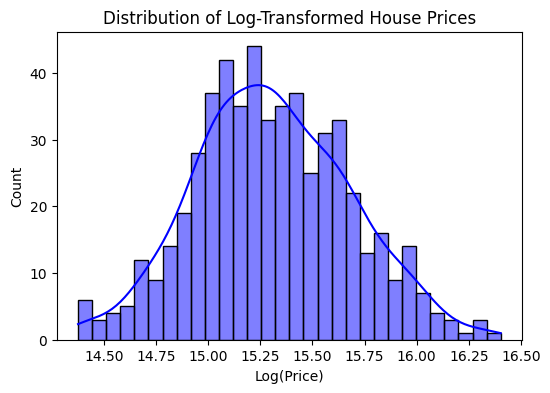

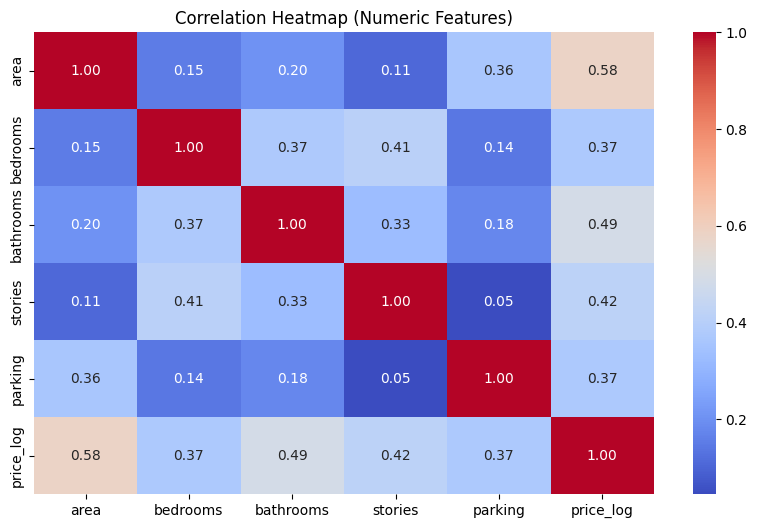

/tmp/ipython-input-1226359737.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette="Set2")


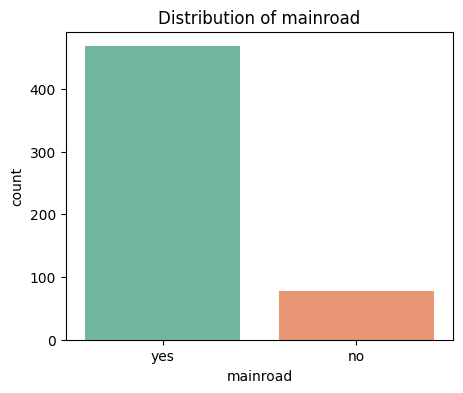

/tmp/ipython-input-1226359737.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette="Set2")


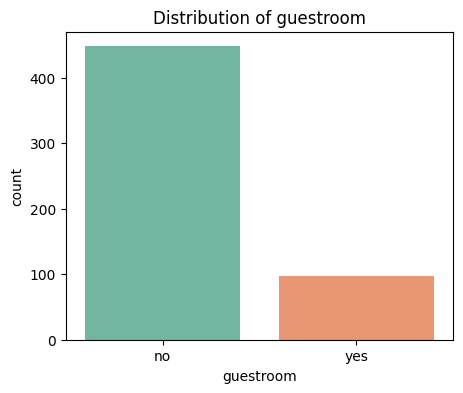

/tmp/ipython-input-1226359737.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette="Set2")


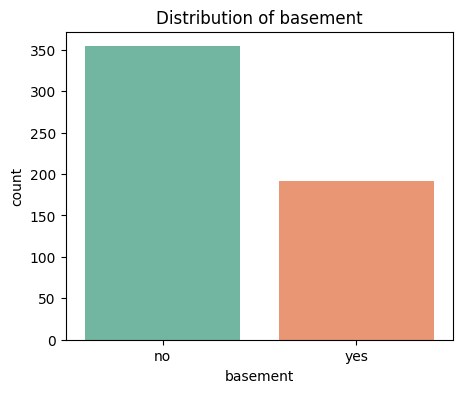

/tmp/ipython-input-1226359737.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette="Set2")


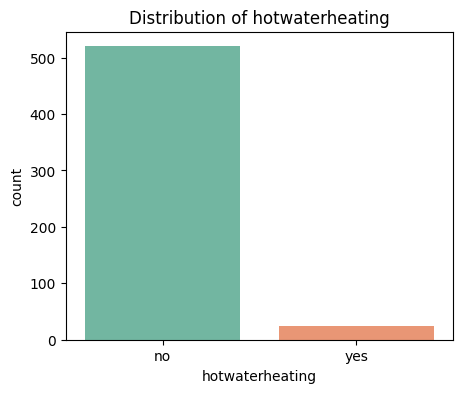

/tmp/ipython-input-1226359737.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette="Set2")


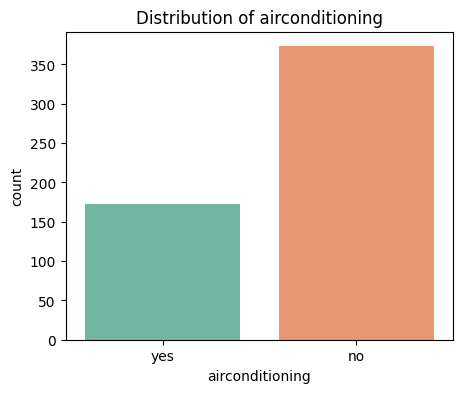

/tmp/ipython-input-1226359737.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette="Set2")


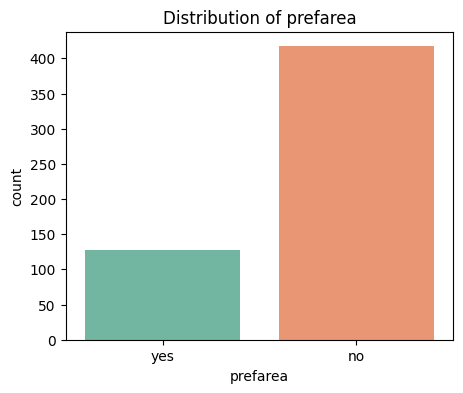

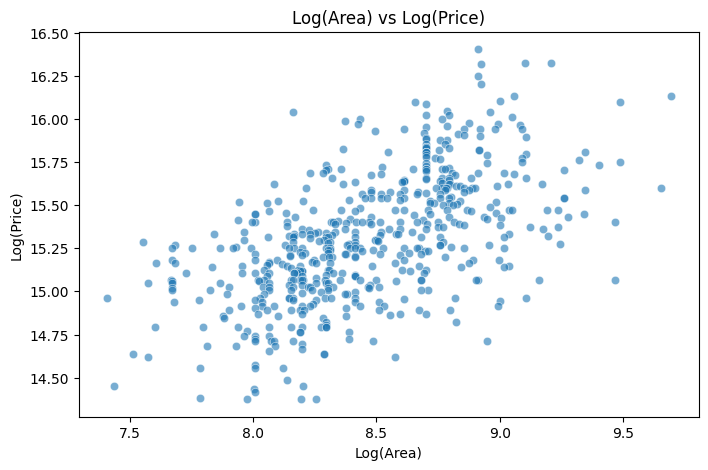

In [31]:
# EDA

# 1) Distribution of target variable (log price)
plt.figure(figsize=(6,4))
sns.histplot(df["price_log"], bins=30, kde=True, color="blue")
plt.title("Distribution of Log-Transformed House Prices")
plt.xlabel("Log(Price)")
plt.ylabel("Count")
plt.show()

# 2) Correlation heatmap (numeric features)
plt.figure(figsize=(10,6))
sns.heatmap(df[numeric_cols.tolist() + ["price_log"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

# 3) Bar plots for categorical yes/no features
for col in categorical_cols:
    plt.figure(figsize=(5,4))
    sns.countplot(x=col, data=df, palette="Set2")
    plt.title(f"Distribution of {col}")
    plt.show()

# 4) Boxplot of area vs price (after log transform)
plt.figure(figsize=(8,5))
sns.scatterplot(x=df["area"], y=df["price_log"], alpha=0.6)
plt.title("Log(Area) vs Log(Price)")
plt.xlabel("Log(Area)")
plt.ylabel("Log(Price)")
plt.show()


In [32]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def evaluate(model, name):
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    # revert log transform for RMSE
    y_true = np.expm1(y_test)
    y_pred = np.expm1(preds)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name}: RMSE={rmse:.2f}, R2={r2:.2f}")
    return pipe

models = {
    "Linear Regression": LinearRegression(),
    "Polynomial Regression (deg=2)": Pipeline([
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("linreg", LinearRegression())
    ]),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Support Vector Regressor": SVR(kernel="rbf"),
    "KNN Regressor": KNeighborsRegressor(n_neighbors=5),
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
}

print("Results")

for name, model in models.items():
    evaluate(model, name)


Results
Linear Regression: RMSE=1326880.84, R2=0.65
Polynomial Regression (deg=2): RMSE=1449426.04, R2=0.58
Decision Tree: RMSE=1546966.19, R2=0.53
Random Forest: RMSE=1441345.89, R2=0.59
Support Vector Regressor: RMSE=1441523.84, R2=0.59
KNN Regressor: RMSE=1498433.40, R2=0.56
XGBoost: RMSE=1464812.73, R2=0.58
